(reglin-pymc-notebook)=
# Analisi bayesiana del modello di regressione lineare bivariato

Nel presente capitolo, esploreremo l'analisi bayesiana applicata al modello di regressione lineare bivariato. 

## Preparazione del Notebook

In [1]:
%run ../_config/config.py # Import the configuration settings
import logging

import cmdstanpy

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from cmdstanpy import CmdStanModel
import seaborn as sns
import pingouin as pg

Per introdurre l'approccio bayesiano, seguiremo la trattazione di {cite:t}`McElreath_rethinking` e analizzeremo nuovamente i dati del censimento dei !Kung San. In precedenza, abbiamo applicato il modello Normale all'altezza. Tuttavia, di solito siamo interessati a modellare come un risultato sia correlato a un'altra variabile, una variabile predittiva. Se la variabile predittiva ha una qualsiasi associazione statistica con la variabile di risultato, possiamo utilizzarla per predire il risultato. Quando la variabile predittiva è integrata nel modello in un modo specifico, otteniamo una regressione lineare.

Ora esaminiamo come l'altezza di questi cacciatori-raccoglitori del Kalahari (la variabile di risultato) covaria con il peso (la variabile predittiva). {cite:t}`McElreath_rethinking` fa notare che questa non è la domanda scientifica più entusiasmante. Tuttavia, è una relazione facile da iniziare a esaminare, e se sembra noiosa, è perché non si ha in mente una teoria sulla crescita e sulla storia della vita. In questo momento, vi chiedo solo di concentrarvi sui meccanismi per stimare un'associazione tra due variabili.

In [2]:
df = pd.read_csv('../data/Howell_18.csv')
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


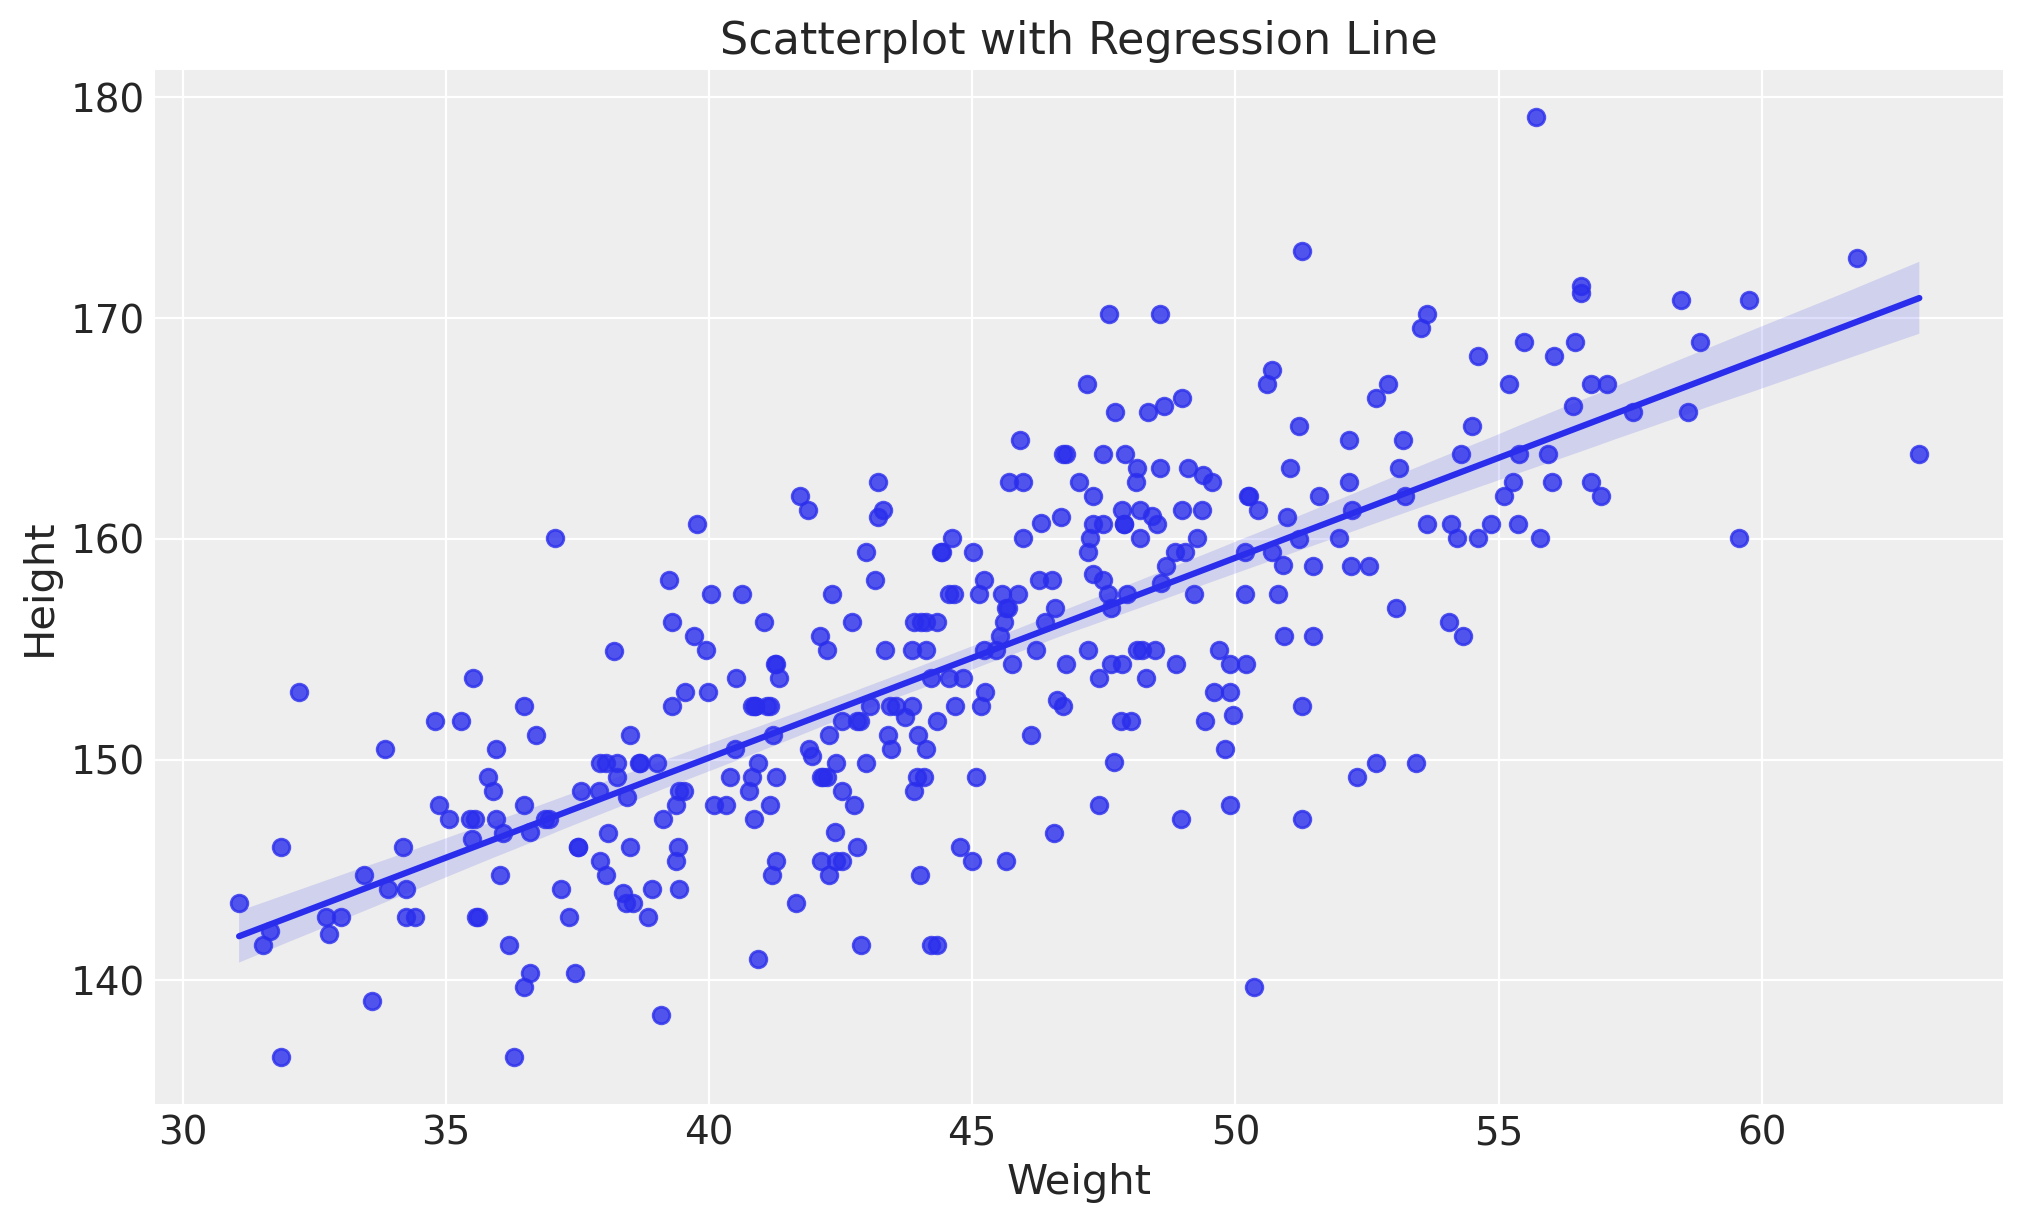

In [3]:
# Create the scatterplot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='weight', y='height', data=df)
plt.title('Scatterplot with Regression Line')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

### Introduzione all'Approccio Bayesiano al Modello di Regressione

L'approccio del modello lineare consiste nel trasformare il parametro della media di una distribuzione Gaussiana, $\mu$, in una funzione lineare della variabile predittiva e di altri nuovi parametri che definiamo. Questa strategia è comunemente nota come "modello lineare". Il modello lineare assume che la variabile predittiva abbia una relazione costante e additiva con la media dell'output. Successivamente, calcola la distribuzione posteriore di questa relazione costante.

### Calcolo della distribuzione posteriore

Il modello lineare esplora tutte le possibili combinazioni dei valori dei parametri. Alcuni di questi parametri descrivono come la media dell'output, $ \mu $, cambia in relazione a un'altra variabile. Per ogni combinazione di valori dei parametri, l'algoritmo calcola la probabilità posteriore, che misura quanto è plausibile quella combinazione data dal modello e dai dati. La distribuzione posteriore classifica quindi tutte le possibili combinazioni dei valori dei parametri in base alla loro plausibilità.

In pratica, la distribuzione posteriore fornisce un'idea di quanto siano probabili diverse relazioni tra le variabili, secondo le assunzioni del modello.

Possiamo quindi chiedere al modello lineare: "Considera tutte le rette che mettono in relazione una variabile con l'altra. Ordina tutte queste rette per plausibilità, dati questi dati." Il modello lineare risponde con una distribuzione posteriore, che rappresenta la plausibilità di ciascuna retta.

### Esempio con una sola variabile predittiva

Nel caso più semplice di una sola variabile predittiva, consideriamo il modello Gaussiano di base:

$$ h_i \sim \text{Normal}(\mu, \sigma) \quad [\text{verosimiglianza}] $$
$$ \mu \sim \text{Normal}(181, 30) \quad [\mu \text{ prior}] $$
$$ \sigma \sim \text{Normal}(0, 20) \quad [\sigma \text{ prior}] $$

Per integrare il peso ($x$) in un modello Gaussiano dell'altezza ($h$), definiamo la media $\mu$ come una funzione dei valori in $x$:

$$ h_i \sim \text{Normal}(\mu_i, \sigma) \quad [\text{verosimiglianza}] $$
$$ \mu_i = \alpha + \beta(x_i - \bar{x}) \quad [\text{modello lineare}] $$
$$ \alpha \sim \text{Normal}(181, 30) \quad [\alpha \text{ prior}] $$
$$ \beta \sim \text{Normal}(0, 10) \quad [\beta \text{ prior}] $$
$$ \sigma \sim \text{Normal}(0, 20) \quad [\sigma \text{ prior}] $$

### Definizione del modello lineare

Nel modello lineare, la media $\mu$ non è più un parametro da stimare direttamente. Come visto nella seconda linea del modello, $\mu_i$ è costruito a partire da altri parametri, $\alpha$ e $\beta$, e dalla variabile osservata $x$. Questa relazione non è stocastica—non c'è un $\sim$, ma un $=$—perché la definizione di $\mu_i$ è deterministica. Una volta noti $\alpha$, $\beta$ e $x_i$, conosciamo $\mu_i$ con certezza.

### Parametri $\alpha$ e $\beta$

Il valore $x_i$ è semplicemente il valore del peso nella riga $i$. I parametri $\alpha$ e $\beta$ sono più misteriosi; li abbiamo inventati. I parametri $\mu$ e $\sigma$ sono necessari e sufficienti per descrivere una distribuzione Gaussiana, ma $\alpha$ e $\beta$ sono strumenti che inventiamo per manipolare $\mu$, permettendole di variare sistematicamente tra i casi nei dati.

### Comprensione dei parametri

Ogni parametro deve essere descritto nella distribuzione posteriore. La seconda linea della definizione del modello:

$$ \mu_i = \alpha + \beta(x_i - \bar{x}) $$

ci dice che stiamo ponendo due domande sulla media dell'output:

1. Qual è l'altezza attesa quando $x_i = \bar{x}$? Il parametro $\alpha$ risponde a questa domanda, poiché quando $x_i = \bar{x}$, $\mu_i = \alpha$. Per questo motivo, $\alpha$ è spesso chiamato l'intercetta.
2. Qual è la variazione attesa nell'altezza quando $x_i$ varia di 1 unità? Il parametro $\beta$ risponde a questa domanda, essendo spesso chiamato la "pendenza" o "coefficiente angolare".

Congiuntamente, questi due parametri chiedono al modello lineare di trovare una linea che mette in relazione $x$ con $h$, una linea che passa attraverso $\alpha$ quando $x_i = \bar{x}$ e ha una pendenza di $\beta$.

In sintesi, l'approccio bayesiano al modello di regressione lineare ci permette di considerare tutte le possibili combinazioni di parametri e di valutare la plausibilità di ciascuna combinazione, data dai dati e dal modello. Questo ci fornisce una comprensione completa e probabilistica delle relazioni tra variabili, incorporando le incertezze e le variazioni presenti nei dati.

L'analisi bayesiana del modello di regressione lineare ci consente di specificare distribuzioni a priori per i parametri $\alpha$, $\beta$ e $\sigma$. Una volta osservati i dati, possiamo calcolare la distribuzione a posteriori di questi parametri. Ciò fornisce una valutazione dell'incertezza nelle stime di $\alpha$ e $\beta$, tenendo conto sia delle informazioni a priori sia delle evidenze fornite dai dati.

Il codice Stan che implementa il modello precedente è contenuto nel file `linreg_height.stan`. Compiliamo e stampiamo il modello.

In [16]:
stan_file = os.path.join(project_directory, 'stan', 'linreg_height.stan')
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * (x- mean(x)), sigma);
  alpha ~ normal(181, 30);
  beta ~ normal(-2, 2);
  sigma ~ normal(0, 20);
}
generated quantities {
  array[N] real y_rep = normal_rng(alpha + beta * x, sigma);
}



Sistemiamo i dati in un dizionario come richiesto del modello Stan.

In [31]:
stan_data = {
    "N": len(df["height"]),
    "x": df["weight"] - np.mean(df["weight"]),
    "y": df["height"]
}

Eseguiamo il campionamento MCMC.

In [32]:
fit = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo le distribuzioni a posteriori dei parametri.

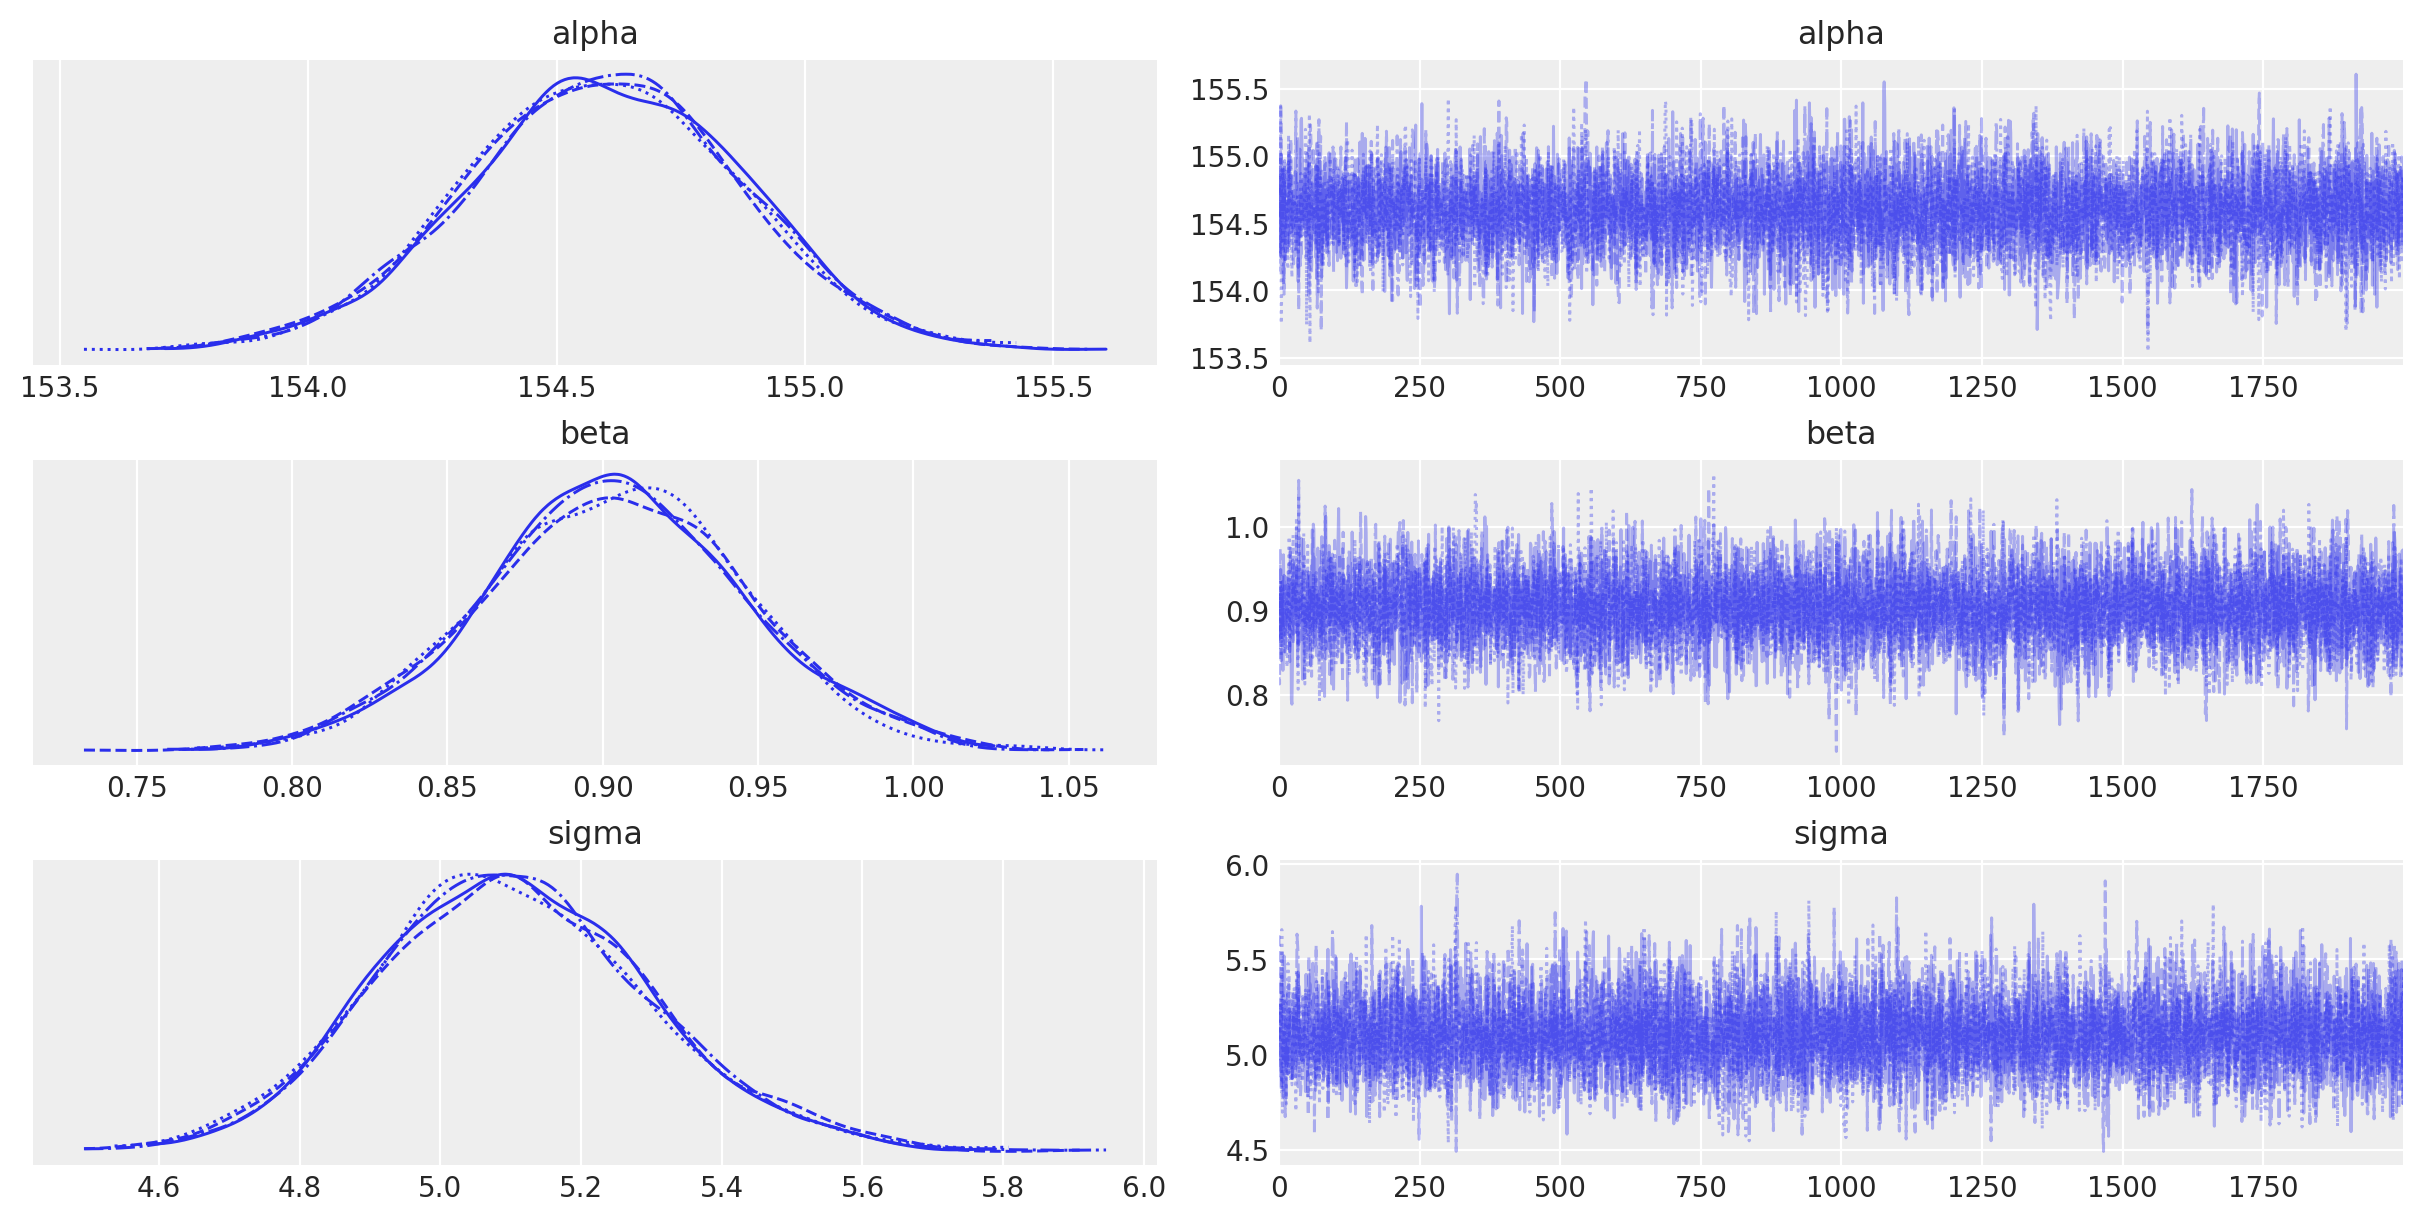

In [33]:
_ = az.plot_trace(fit, var_names=(["alpha", "beta", "sigma"]))

L'oggetto `fit` generato da `cmdstanpy` appartiene alla classe `cmdstanpy.stanfit.mcmc.CmdStanMCMC`. Questo oggetto è funzionalmente equivalente a un oggetto della classe `InferenceData`, permettendo quindi la sua manipolazione tramite le funzioni fornite da ArviZ. Esaminiamo dunque un sommario delle distribuzioni a posteriori dei parametri del modello lineare.

In [34]:
az.summary(fit, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,154.594,0.278,154.066,155.112,0.003,0.002,7707.0,5702.0,1.0
beta,0.904,0.042,0.823,0.983,0.000,0.000,8612.0,6334.0,1.0
sigma,5.104,0.195,4.747,5.482,0.002,0.002,8641.0,6071.0,1.0


Avendo definito nel modello il predittore lineare come $x - \bar{x}$, l'intercetta corrisponderà alla media dei valori dell'altezza. La pendenza $\beta$ ci informa sull'incremento atteso dell'altezza quando il peso aumenta di un'unità. Il parametro $\sigma$ descrive la deviazione standard della dispersione dei dati attorno alla retta di regressione.

Confrontiamo i valori ottenuti con l'approccio bayesiano con quelli trovati usando la procedura di massima verosimiglianza.

In [35]:
lm = pg.linear_regression(df["weight"] - np.mean(df["weight"]), df["height"])
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,154.60,0.27,570.25,0.0,0.57,0.57,154.06,155.13
1,weight,0.91,0.04,21.52,0.0,0.57,0.57,0.82,0.99


La somiglianza tra le due soluzioni conferma che, nel caso di modelli semplici come questo, e quando vengono usati dei prior debolmente informativi, i due approcci producono risultati sostanzialmente equivalenti.

Per creare un PPC plot dobbiamo creare un oggetto InferenceData nel quale i dati sono strutturati come si aspetta ArviZ:

In [37]:
idata = az.from_cmdstanpy(
    posterior=fit,
    posterior_predictive='y_rep',
    observed_data={'y': df["height"]},
)

Esaminiamo ora il pp-check. 

/opt/anaconda3/envs/cmdstan_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


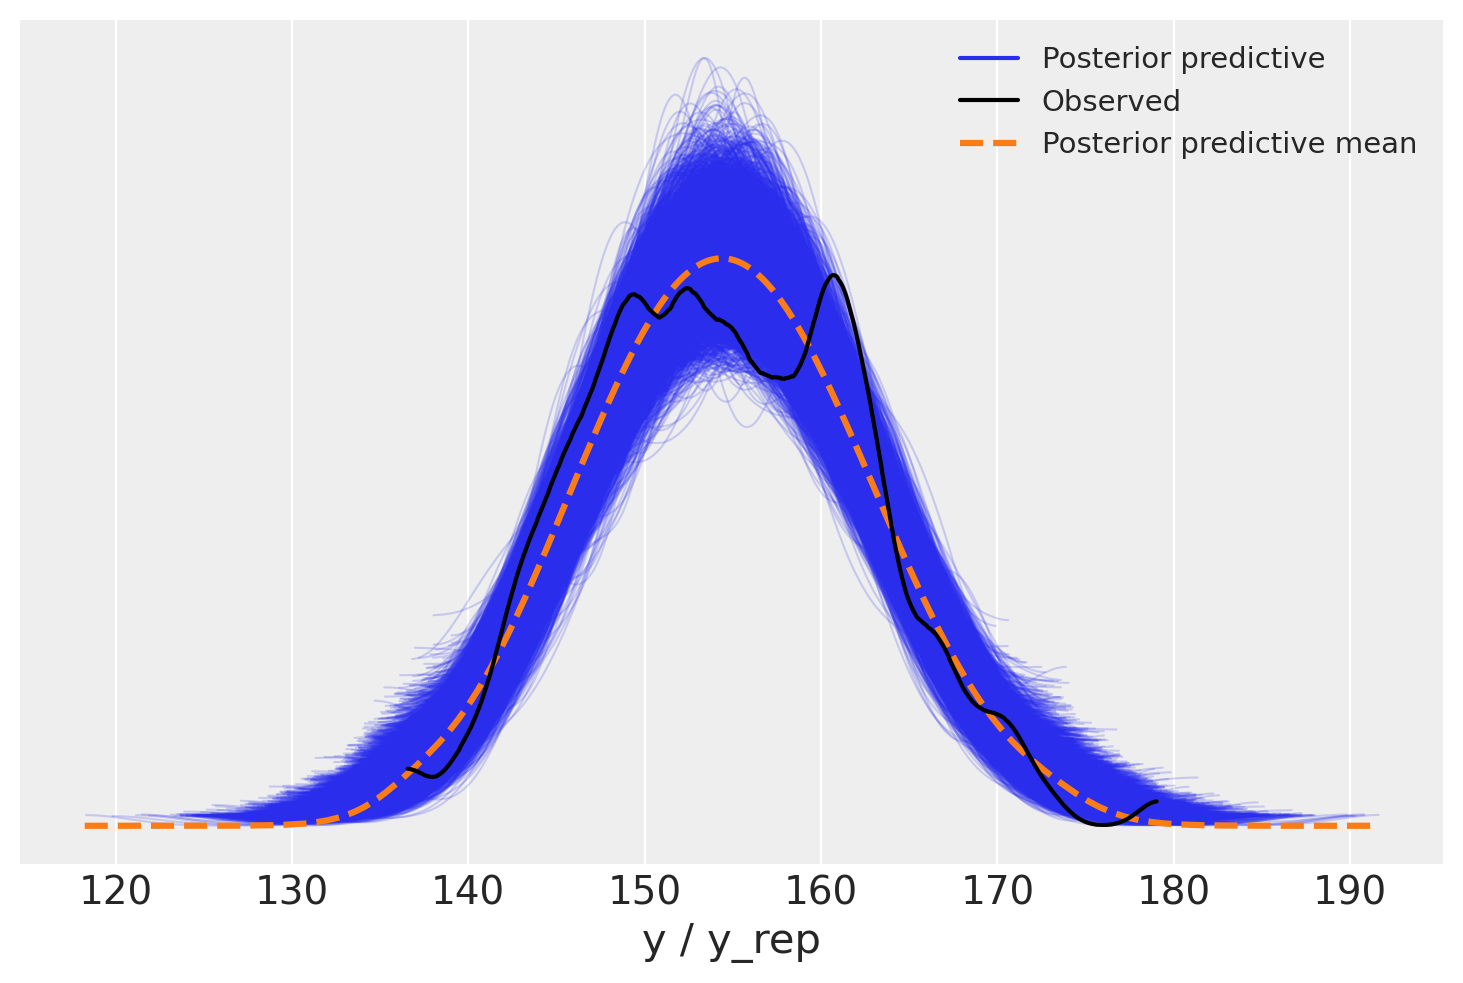

In [38]:
_ = az.plot_ppc(idata, data_pairs={'y': 'y_rep'})

Costruiamo ora un grafico che rappresenta i valori osservati insieme alla linea di regressione stimata tramite il modello bayesiano. Al grafico aggiungeremo diverse linee di regressione, ciascuna orientata in base ai valori campionati casualmente dalla distribuzione a posteriori dei parametri $\alpha$ e $\beta$.

In [39]:
# Extract posterior samples
alpha_samples = fit.stan_variable("alpha")
beta_samples = fit.stan_variable("beta")

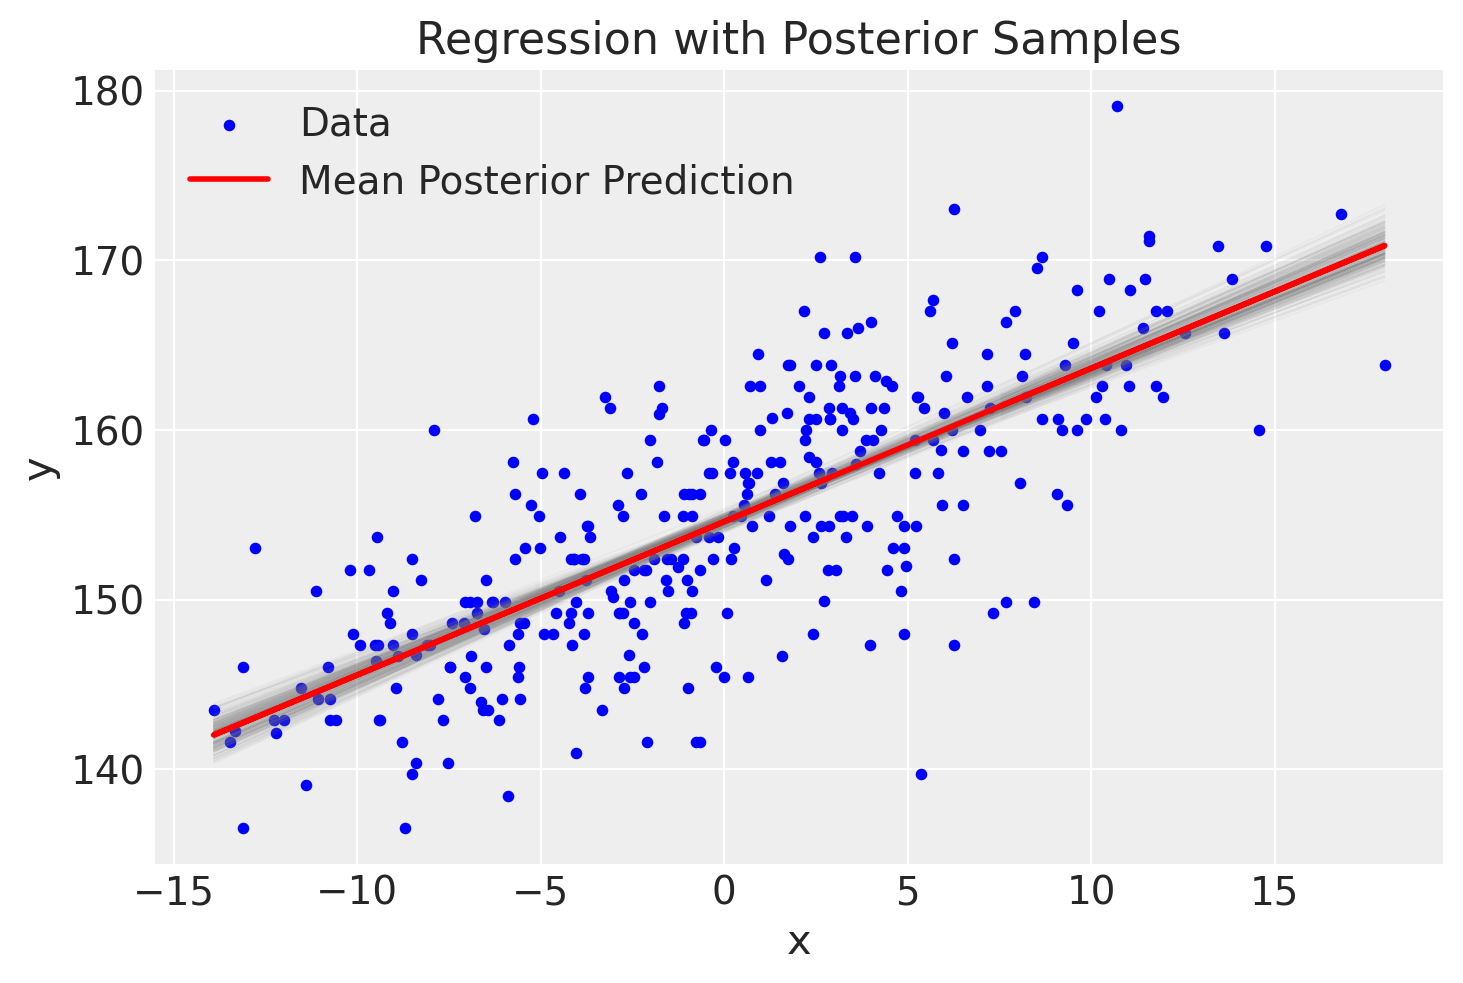

In [42]:
# Plot y vs x
x = df["weight"] - np.mean(df["weight"])
plt.scatter(x, df["height"], color="blue", label="Data", s=10)  # s is the size of the point

# Draw lines from posterior samples
for i in range(300):  # assuming you have at least 300 samples
    plt.plot(
        x,
        alpha_samples[i] + beta_samples[i] * x,
        color="gray",
        linestyle="-",
        linewidth=0.5,
        alpha=0.05,
    )

# Line using the mean of posterior estimates
mean_alpha = np.mean(alpha_samples)
mean_beta = np.mean(beta_samples)
plt.plot(
    x,
    mean_alpha + mean_beta * x,
    color="red",
    linewidth=2,
    label="Mean Posterior Prediction",
)

# Additional plot formatting
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression with Posterior Samples")
plt.legend()
plt.show()

Le numerose linee di regressione presenti nel grafico visualizzano la nostra incertezza riguardo l'inclinazione esatta della linea di regressione principale. Tuttavia, il grafico mostra chiaramente che questa incertezza è minima.

## Commenti e considerazioni finali

In questo capitolo abbiamo esplorato la stima dei parametri di un modello di regressione bivariato utilizzando l'approccio bayesiano.

Per fornire un confronto con un metodo alternativo, in appendice è presentata un'introduzione all'approccio frequentista per il modello di regressione lineare bivariato. Questa sezione aggiuntiva offre una panoramica degli aspetti chiave dell'approccio frequentista, consentendo di confrontare e comprendere le differenze tra i due approcci nella stima dei parametri e nell'interpretazione dei risultati.

## Informazioni sull'Ambiente di Sviluppo

In [50]:
%load_ext watermark
%watermark -n -u -v -iv -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Apr 22 2024

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.2
arviz     : 0.18.0
matplotlib: 3.8.4
pymc      : 5.13.0
numpy     : 1.26.4
seaborn   : 0.13.2
xarray    : 2024.3.0
scipy     : 1.13.0

